In [463]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image
import plotly.graph_objects as go
import sklearn.preprocessing 
import sklearn.linear_model
from sklearn.metrics import mean_squared_error
import sklearn.model_selection
from sklearn.feature_selection import RFE

In [464]:
df = pd.read_csv('forestfires.csv')
df

X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain   area
0    7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.00
1    7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.00
2    7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.00
3    8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.00
4    8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.00
..  .. ..   ...  ...   ...    ...    ...   ...   ...  ..   ...   ...    ...
512  4  3   aug  sun  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0   6.44
513  2  4   aug  sun  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0  54.29
514  7  4   aug  sun  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  11.16
515  1  4   aug  sat  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0   0.00
516  6  3   nov  tue  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0   0.00

[517 rows x 13 columns]

# EDA

### Типы данных столбцов

In [465]:
df.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

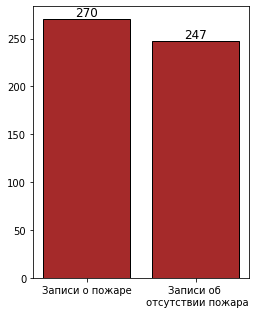

In [466]:
fire_counts = df[df['area']!=0].count()[0]
nofire_counts = df[df['area']==0].count()[0]

plt.subplots_adjust(left = 0.1, right=0.3)
bars = plt.bar(['Записи о пожаре', 'Записи об \n отсутствии пожара'], [fire_counts, nofire_counts], 
               color='brown', edgecolor = 'black')
plt.bar_label(bars, fontsize = 12)
plt.show()

### Чаще всего пожары случаются в регионах с координатами долготы 2, 4, в средней полосе

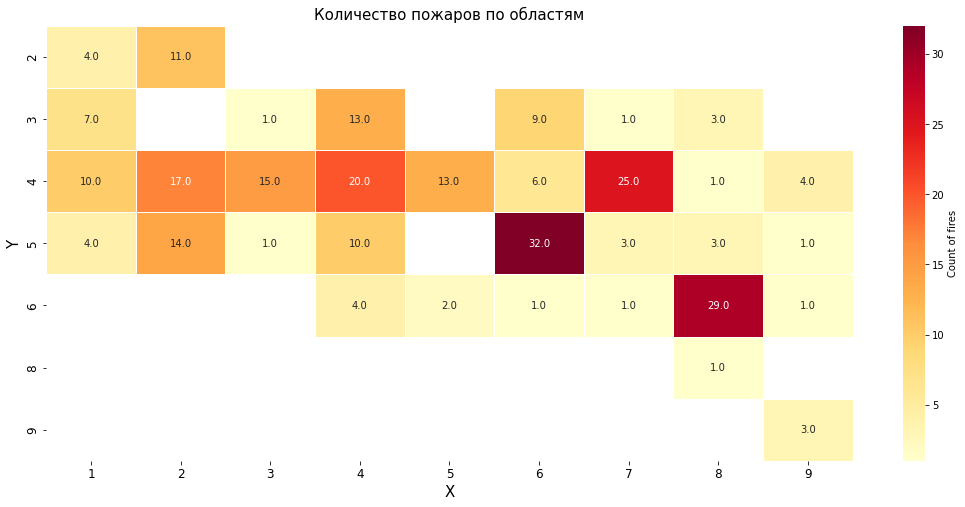

In [467]:
def XY(row):
    return (str(row['X']) + '|' + str(row['Y']))

vis = df
vis['X|Y'] = vis.apply(XY, axis = 1)
vis = vis[vis['area']!=0]
values = vis['X|Y'].to_list()
index = vis['area'].to_list()
size = pd.Series(values, index).value_counts().sort_index()

X, Y = [], []
for i in size.index:
    X.append(int(i.split('|')[0]))
    Y.append(int(i.split('|')[1]))
    
data = pd.DataFrame({'X': X, 'Y': Y, 'Count of fires': size})
heatmap_data = pd.pivot_table(data, values='Count of fires', index='Y', columns='X')

plt.figure(figsize = (14,8))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt=".1f", linewidths=.5, cbar_kws={'label': 'Count of fires'},
            xticklabels=1, yticklabels=1)

plt.xlabel('X', fontsize = 15)
plt.ylabel('Y', fontsize = 15)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.title('Количество пожаров по областям', fontsize = 15)
plt.subplots_adjust(left=0, right=1)
plt.show()
df.drop('X|Y', axis= 1 , inplace= True )

### Наиболее часто возгорания происходят в августе и сентябре

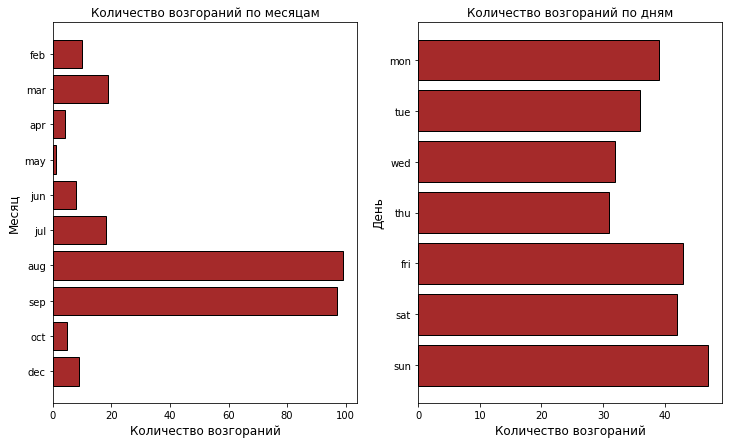

In [468]:
month = ['feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'dec']
month_number = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12]

mo = df[df['area'] != 0]['month'].value_counts()
mo = mo.rename(index={month[i]:month_number[i] for i in range(len(month))}).sort_index(ascending=False)
mo = mo.rename(index={month_number[i]:month[i] for i in range(len(month))})

days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
day = df[df['area'] != 0]['day'].value_counts()
day = day.rename(index={days[i]:(i+1) for i in range(len(days))}).sort_index(ascending=False)
day = day.rename(index={(i+1):days[i] for i in range(len(days))})

plt.figure(figsize = (12,7))
m = plt.subplot(1,2,1)
m.barh(mo.index, mo, color='brown', edgecolor = 'black')
plt.title('Количество возгораний по месяцам')
plt.xlabel('Количество возгораний', fontsize=12)
plt.ylabel('Месяц', fontsize=12)

d = plt.subplot(1,2,2)
d.barh(day.index, day, color='brown', edgecolor = 'black')
plt.title('Количество возгораний по дням')
plt.xlabel('Количество возгораний', fontsize=12)
plt.ylabel('День', fontsize=12)

plt.show()

### Частотные распределения погодных признаков имеют смещения, можно попробовать нормализацию

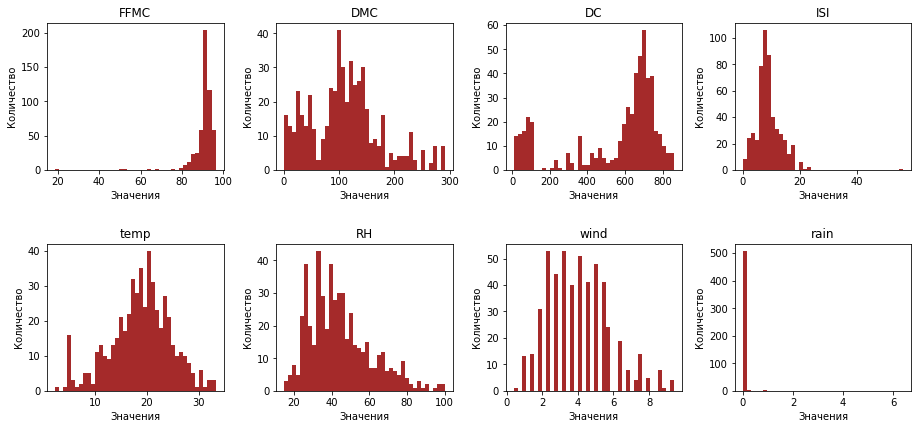

In [469]:
c = [column for column in df][4:12]
plt.figure(figsize=(15,7))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.hist(df.iloc[:, [i+4]],bins = 40, color = 'brown')
    plt.title(c[i])
    plt.xlabel('Значения')
    plt.ylabel('Количество')
plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=1.0, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.5)
plt.show()

#### Обработаем выбросы в FFMC, ISI, rain

In [470]:
#выбросы признака FFMC
df.drop(df.loc[df['FFMC'] < 60].index, inplace=True)

#выбросы признака ISI
df.drop(df.loc[df['ISI'] > 25].index, inplace=True)

#выбросы признака rain
df.drop(df.loc[df['rain'] > 2].index, inplace=True)

### Корреляции признаков

In [471]:
df_new = df.iloc[:, [0,1,4,5,6,7,8,9,10,11,12,3]]
corr = df_new.corr()
corr.style.background_gradient(cmap='YlOrRd')

C:\Users\HUAWEI\AppData\Local\Temp/ipykernel_22448/3819992626.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_new.corr()


### Площадь возгорания имеет большой разброс

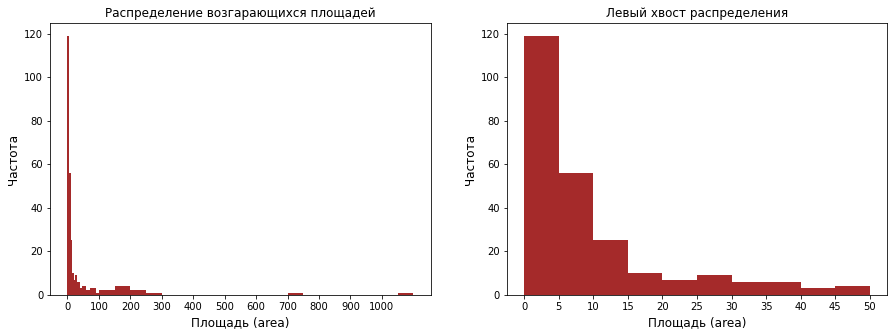

In [472]:
area = df[df['area']!=0]['area']
bins_5 = [5*i for i in range(11)]
bins_10 = [bins_5[-1] + 10*i for i in range(1, 6)]
bins_50 = [bins_10[-1] + 50*i for i in range(1, 21)]
bins = bins_5 + bins_10 + bins_50

area_50 = area[area <= 50]

plt.rcParams ['figure.figsize'] = [15, 5]

plt.subplot(1,2,1)
plt.hist(area, bins = bins, color='brown')
plt.xticks(np.arange(0, 1100, step=100))
plt.title('Распределение возгарающихся площадей')
plt.xlabel('Площадь (area)', fontsize = 12)
plt.ylabel('Частота', fontsize = 12)

plt.subplot(1,2,2)
plt.hist(area_50, bins = [5*i for i in range(11)], color = 'brown')
plt.xticks(np.arange(0,51,step=5))
plt.title('Левый хвост распределения')
plt.xlabel('Площадь (area)', fontsize = 12)
plt.ylabel('Частота', fontsize = 12)

plt.show()

#### Обработаем выбросы

In [473]:
df.drop(df.loc[df['area'] > 50].index, inplace=True)

### Применим преобразование ln(x+1) к столбцу area, чтобы сжать данные к левому хвосту

In [474]:
df['area'] = df['area'].apply(lambda x: np.log(x+1))

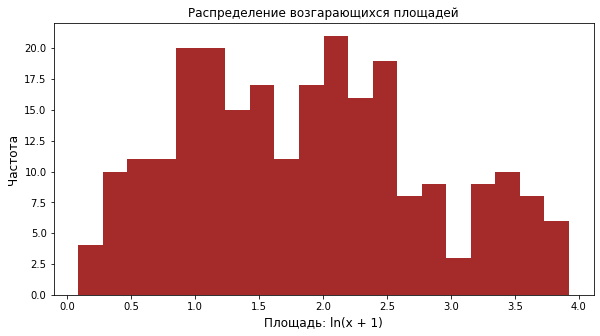

In [475]:
area = df[df['area']!=0]['area']

plt.rcParams ['figure.figsize'] = [15, 5]
plt.hist(area, bins = 20, color='brown')
plt.title('Распределение возгарающихся площадей')
plt.xlabel('Площадь: ln(x + 1)', fontsize = 12)
plt.ylabel('Частота', fontsize = 12)
plt.subplots_adjust(left=0, right=0.5)
plt.show()

#### Вывод: удалось собрать данные в левом хвосте

# Training

#### One Hot Encoding, Mixing and Splitting

In [476]:
#OneHotEncoding
ohe = sklearn.preprocessing.OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).set_output(transform='pandas')

ohetransform_m = ohe.fit_transform(df[['month']])
df = pd.concat([df, ohetransform_m], axis = 1).drop(columns='month')

ohetransform_d = ohe.fit_transform(df[['day']])
df = pd.concat([df, ohetransform_d], axis = 1).drop(columns='day')

In [477]:
#Меняем порядок столбцов
area = df['area']
df = df.drop('area', axis=1)

df.insert(df.shape[1], 'area', area)

In [478]:
#Замешиваем датасет
df_sample = df.sample(frac=1, random_state=1) #перемешиваем

In [479]:
#Делим на train и test
cut = int(.75*len(df))
train = df_sample.iloc[:cut] #тренировочный датасет
X_train, Y_train = [train.iloc[:, [i for i in range(29)]], train.iloc[:, [29]]] #тренировочные данные

test = df_sample.iloc[cut:] #тестовый датасет
X_test, Y_test = [test.iloc[:, [i for i in range(29)]], test.iloc[:, [29]]] #тестовые данные

### Training

#### Linear model

In [480]:
linear = sklearn.linear_model.LinearRegression()
linear.fit(X_train, Y_train)

LinearRegression()

In [481]:
linear_prediction = linear.predict(X_test)

#Обратное логарифмическое преобразование
linear_prediction = pd.DataFrame(linear_prediction).apply(lambda x: np.exp(x) - 1)
Y_test = Y_test.apply(lambda x: np.exp(x) - 1)

linear_rmse = np.sqrt(mean_squared_error(linear_prediction, Y_test))

print('RMSE после обратного логарифмического преобразования:', linear_rmse)

RMSE после обратного логарифмического преобразования: 7.636250936515745


#### Score on Cross-Validation

In [482]:
linear_cv = sklearn.linear_model.LinearRegression()
cv = sklearn.model_selection.KFold(n_splits = 5, shuffle = True, random_state = 42)

score = abs(sklearn.model_selection.cross_val_score(estimator = linear_cv,
                                                    X = df_sample.iloc[:, [i for i in range(29)]], 
                                                    y = df_sample.iloc[:, [29]],
                                                    cv = cv,
                                                    scoring = 'neg_mean_squared_error'))
mean_cv_score = np.mean(np.sqrt(score))
print('Mean score on cross-validation without the inverse logarithmic transformation: ', mean_cv_score)

Mean score on cross-validation without the inverse logarithmic transformation:  1.2021804578549227


### Отбор признаков с помощью RFE

In [483]:
#ранжируем фичи про влиянию на предсказания
linear = sklearn.linear_model.LinearRegression()
selector = RFE(linear, n_features_to_select=10, step=1)
selector = selector.fit(X_test, Y_test)
print('Значение i-го элемента характеризует влияние i-го признака, 10 выбраны приоритетными:', '\n', 
      selector.ranking_)

Значение i-го элемента характеризует влияние i-го признака, 10 выбраны приоритетными: 
 [12 11  6 16 15  9 13 14 17  1  5  1  1  1 19  1  1  1 20 18 10  8  7  4
  3  1  2  1  1]


In [484]:
#отбираем 10 наиболее влиятельных признаков
threshold_level = 1
unnecessary = [index for index, value in enumerate(selector.ranking_) if value > threshold_level]
X_test.drop(X_test.columns[[i for i in unnecessary]], axis = 1, inplace = True)
X_train.drop(X_train.columns[[i for i in unnecessary]], axis = 1, inplace = True)

C:\Users\HUAWEI\AppData\Local\Temp/ipykernel_22448/1973307075.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(X_test.columns[[i for i in unnecessary]], axis = 1, inplace = True)
C:\Users\HUAWEI\AppData\Local\Temp/ipykernel_22448/1973307075.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(X_train.columns[[i for i in unnecessary]], axis = 1, inplace = True)


In [485]:
#обучаем модель с меньшим кол-вом признаков
new_linear = sklearn.linear_model.LinearRegression()
new_linear.fit(X_train, Y_train)

new_linear_prediction = new_linear.predict(X_test)
new_linear_prediction = pd.DataFrame(new_linear_prediction).apply(lambda x: np.exp(x) - 1)

new_rmse = np.sqrt(mean_squared_error(new_linear_prediction, Y_test))
print('RMSE после обратного логарифмического преобразования и отбора 10 лучших признаков:', new_rmse)

RMSE после обратного логарифмического преобразования и отбора 10 лучших признаков: 7.671037429825308


In [486]:
print('RMSE классической регрессии до выделения ключевых признаков:', linear_rmse.round(5))
print('RMSE классической регрессии после выделения ключевых признаков:', new_rmse.round(5),'\n')
print('Вывод: изменение ', round(abs(linear_rmse.round(5) - new_rmse.round(5)),5), ' незначительное для данной задачи')

RMSE классической регрессии до выделения ключевых признаков: 7.63625
RMSE классической регрессии после выделения ключевых признаков: 7.67104 

Вывод: изменение  0.03479  незначительное для данной задачи


In [487]:
print('10 наиболее влияющих на предсказание признаков:', '\n', [i for i in X_train.columns])

10 наиболее влияющих на предсказание признаков: 
 ['rain', 'month_aug', 'month_dec', 'month_feb', 'month_jul', 'month_jun', 'month_mar', 'day_sun', 'day_tue', 'day_wed']


In [488]:
print('Среднее значение предсказанной величины после обратного логарифмического преобразования: ', 
      round(new_linear_prediction.mean()[0],4))
print('Следовательно, модель чаще предсказывает небольшие возгарания')

Среднее значение предсказанной величины после обратного логарифмического преобразования:  1.9566
Следовательно, модель чаще предсказывает небольшие возгарания


#### Наилучшего качества модели удалось добиться при 5 признаках (когда остаются только некоторые месяцы), но логика подсказывает, что валидацию такая модель не пройдет, вероятно как и модель с 10ю ключевыми признаками

### Lasso & Ridge

In [489]:
train = df_sample.iloc[:cut] #тренировочный датасет
X_train, Y_train = [train.iloc[:, [i for i in range(29)]], train.iloc[:, [29]]] #тренировочные данные

test = df_sample.iloc[cut:] #тестовый датасет
X_test, Y_test = [test.iloc[:, [i for i in range(29)]], test.iloc[:, [29]]] #тестовые данные

#### Ridge

In [490]:
ridge = sklearn.linear_model.Ridge(alpha=1.0)
ridge.fit(X_train, Y_train)

Ridge()

In [491]:
ridge_prediction = pd.DataFrame(ridge.predict(X_test)).apply(lambda x: np.exp(x) - 1)
Y_test = Y_test.apply(lambda x: np.exp(x) - 1)

ridge_rmse = np.sqrt(mean_squared_error(ridge_prediction, Y_test))
print('RMSE:', ridge_rmse)

RMSE: 7.71616968424261


In [492]:
print('Среднее значение предсказанной величины после обратного логарифмического преобразования: ', 
      round(ridge_prediction.mean()[0],4))
print('Следовательно, модель чаще предсказывает небольшие возгарания')

Среднее значение предсказанной величины после обратного логарифмического преобразования:  1.9274
Следовательно, модель чаще предсказывает небольшие возгарания


#### Lasso

In [493]:
lasso = sklearn.linear_model.Lasso(alpha=1.0)
lasso.fit(X_train, Y_train)

Lasso()

In [494]:
lasso_prediction = pd.DataFrame(lasso.predict(X_test)).apply(lambda x: np.exp(x) - 1)
lasso_rmse = np.sqrt(mean_squared_error(lasso_prediction, Y_test))
print('RMSE:', lasso_rmse)

RMSE: 8.009063990627407


# Выводы

Если не производить преобразования колонки AREA как ln(x+1) и принять выбросами значения AREA > 15, то RMSE получаются такие:  
  
<b>Классическая линейная регрессия:</b> 3.7174  
<b>Среднее на кросс-валидации по 5 подмножествам:</b> 3.7814  
<b>Классическая линейная регрессия после выделения 10 ключевых признаков:</b> 3.6889  
<b>Ridge-регрессия:</b> 3.7325  
<b>Lasso-регрессия:</b> 3.7814  
  
  
   

В процессе исследовательского анализа данных были удалены выбросы.  
Корреляционный анализ показал, что проблема мультиколлинеарности признаков вряд ли сделает предсказания модели хуже. Последнюю гипотезу подтвердило обучение моделей Lasso & Ridge, которые показали примерно такие же результаты, как и классическая линейная регрессия.  
  
Из-за того, что объектов с таргетом AREA > 50 в датасете немного, эти объекты были отброшены, после было применено сжимающее отображение, которое позволило собрать данные в левом хвосте с меньшей дисперсией.  
  
Всего было обучено 4 модели: линейная регрессия, линейная регрессия с отбором 10 наиболее влияющих на предсказания первой признаков, Lasso & Ridge регрессии

Значения RMSE после обратного логарифмического преобразования:  
<b>Классическая линейная регрессия:</b> 7.6363  
<b>Классическая линейная регрессия после выделения 10 ключевых признаков:</b> 7.6710  
<b>Ridge-регрессия:</b> 7.7162  
<b>Lasso-регрессия:</b> 8.0091  

### Качество предсказаний моделей находится в диапазоне от 7.64 до 8.01, с такими результатами леса будут гореть и довольно сильно, к сожалению